# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, Oct 29, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1KIIl8MNYpuvk89FA9Nq-h-ltq_83xAkT/view?usp=sharing

In [ ]:
import csv
import time
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tensorflow as tf

In [ ]:
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)
#df.info # Print a concise summary of a DataFrame.

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
# print minimum, maximum, and average value for ["age", "yredu", "capgain", "caploss", "workhr"]
selected_features = ["age", "yredu", "capgain", "caploss", "workhr"]
for feature in selected_features:
  print("Selected feature:", feature)
  print("Max value=", df[feature].max())
  print("Min value=", df[feature].min())
  print("Average=", round(df[feature].mean()))
  print()

Selected feature: age
Max value= 1.0
Min value= 0.0
Average= 0

Selected feature: yredu
Max value= 1.0
Min value= 0.0
Average= 1

Selected feature: capgain
Max value= 1.0
Min value= 0.0
Average= 0

Selected feature: caploss
Max value= 1.0
Min value= 0.0
Average= 0

Selected feature: workhr
Max value= 1.0
Min value= 0.0
Average= 0



In [ ]:
# normalizing ["age", "yredu", "capgain", "caploss", "workhr"]
selected_features = ["age", "yredu", "capgain", "caploss", "workhr"]
for feature in selected_features:
  x = df[feature]
  normalized_value = (x - x.min())/(x.max() - x.min())
  x.update(normalized_value)

# print first 3 samples after nomalization
print(df[["age", "yredu", "capgain", "caploss", "workhr"]])

            age     yredu   capgain  caploss    workhr
0      0.301370  0.800000  0.021740      0.0  0.397959
1      0.452055  0.800000  0.000000      0.0  0.122449
2      0.287671  0.533333  0.000000      0.0  0.397959
3      0.493151  0.400000  0.000000      0.0  0.397959
4      0.150685  0.800000  0.000000      0.0  0.397959
...         ...       ...       ...      ...       ...
32556  0.136986  0.733333  0.000000      0.0  0.377551
32557  0.315068  0.533333  0.000000      0.0  0.397959
32558  0.561644  0.533333  0.000000      0.0  0.397959
32559  0.068493  0.533333  0.000000      0.0  0.193878
32560  0.479452  0.533333  0.150242      0.0  0.397959

[32561 rows x 5 columns]


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
num_of_male = sum(df["sex"] == " Male")
num_of_female = sum(df["sex"] == " Female")
total_num_of_people = len(df)
print("percentage of Male=", round(num_of_male/total_num_of_people*100, 2), "%")
print("percentage of Female=", round(num_of_female/total_num_of_people*100, 2), "%")

percentage of Male= 66.92 %
percentage of Female= 33.08 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]
print("# 0f rows that contains missing features =", len(df_with_missing))
print("percentage of rows were removed = ", round(len(df_with_missing)/len(df)*100, 2), "%")

# 0f rows that contains missing features = 1843
percentage of rows were removed =  5.66 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
work_types = df_not_missing["work"].unique()
print(df_not_missing["work"].nunique(), "possible values in the feature 'work':")
for work in work_types:
  print(work)

7 possible values in the feature 'work':
 State-gov
 Self-emp-not-inc
 Private
 Federal-gov
 Local-gov
 Self-emp-inc
 Without-pay


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("columns=", len(data.columns))

columns= 57


In [ ]:
# selected continuous and categorical features
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]

num_of_continuous_features = len(contcols)
num_of_categorical_variables = 0
for feature in catcols:
  # Count distinct values in each categorical features
  count = df_not_missing[feature].nunique()
  num_of_categorical_variables += count

print("# of continuous features =", num_of_continuous_features)
print("# of categorical variables =", num_of_categorical_variables)
print("# of columns =", num_of_continuous_features + num_of_categorical_variables)

# of continuous features = 5
# of categorical variables = 52
# of columns = 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
data.keys()

Index(['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work_ Federal-gov',
       'work_ Local-gov', 'work_ Private', 'work_ Self-emp-inc',
       'work_ Self-emp-not-inc', 'work_ State-gov', 'work_ Without-pay',
       'marriage_ Divorced', 'marriage_ Married-AF-spouse',
       'marriage_ Married-civ-spouse', 'marriage_ Married-spouse-absent',
       'marriage_ Never-married', 'marriage_ Separated', 'marriage_ Widowed',
       'occupation_ Adm-clerical', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving', 'edu_ 10th',
       'edu_ 11th', 'edu_ 12th', 'edu_ 1st-4th', 'edu_ 5th-6th',
       'edu_ 7th-8th', 'edu_ 9th'

In [ ]:
cat_index = {}  # Mapping of feature -> starting index of a categorical feature in data
cat_values = {} # Mapping of feature -> list of categorical values of each feature

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header contains '_'
        feature, value = header.split() # E.g.: header = work_ Private, feature = work_, value = Private
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

#print cat_index & cat_values
print(cat_index)
print(cat_values)

# return the categorical values of a given feature in a given row. E.g.: output: values of 'work_ Federal-gov,	work_ Local-gov,	work_ Private,	work_ Self-emp-inc,	work_ Self-emp-not-inc,	work_ State-gov, work_ Without-pay'
def get_onehot(record, feature): # records = rows
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices from 5th to 12th in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    max_value = np.amax(onehot)
    indices = np.where(onehot == max_value)
    # indices is a tuple
    return cat_values[feature][int(indices[0])]

ret = get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
print(ret)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
np.random.shuffle(datanp)
total_samples = len(data)
split1 = int(total_samples*0.7)
split2 = int(total_samples*0.85)

train_data = datanp[:split1]
val_data = datanp[split1:split2]
test_data = datanp[split2:]

print("# of training data=", len(train_data))
print("# of validation data=", len(val_data))
print("# of testing data=", len(test_data))

# of training data= 21502
# of validation data= 4608
# of testing data= 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, hu1, hu2):
        self.hu1 = hu1
        self.hu2 = hu2
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, self.hu1),
            nn.ReLU(),
            nn.Linear(self.hu1, self.hu2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.hu2, self.hu1),
            nn.ReLU(),
            nn.Linear(self.hu1, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Answer:


*   For continuous features, we have normalized them between 0 and. For categorical features, we have converted them into one-hot embeddings, which are also betowwen 0 and 1. Since all the values are between 0 and 1, we use the sigmoid to regulate the range of output between 0 and 1. 



## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    # there will be multiple rows(records), so we want to zero out all given records for given features
    records[:, start_index:stop_index] = 0 
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, batch_size, learn_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learn_rate,
                                                   epoch)
    return path

def plotting(iterations, t_loss, v_loss, t_acc, v_acc):
    plt.title("Training/Validation Loss Curves")
    plt.plot(iterations, t_loss, label="Training")
    plt.plot(iterations, v_loss, label="Validation")
    plt.xlabel("# of iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training/Validation Accuracy Curves")
    plt.plot(iterations, t_acc, label="Training")
    plt.plot(iterations, v_acc, label="Validation")
    plt.xlabel("# of iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4, use_cuda=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/validation loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    intrations = np.zeros(num_epochs)

    # training started
    print ("Training Started...")
    start_time = time.time()

    for epoch in range(num_epochs):
        for data in train_loader:

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
              model = model.cuda()
            #############################################

            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature for all samples
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # get accuracy and loss for this epoch on training data
        train_acc[epoch], train_loss[epoch] = get_accuracy(model, train_loader, criterion=criterion, use_cuda=use_cuda)
        # get accuracy and loss for this epoch on validation data
        val_acc[epoch], val_loss[epoch] = get_accuracy(model, valid_loader, criterion=criterion, use_cuda=use_cuda)
        #get number of iterations
        intrations[epoch] = (epoch)

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        # displaying the epochs performance
        print(("Epoch {}: Train acc: {}, Train loss: {} | Validation acc: {}, Validation loss: {}").format(
            epoch + 1,
            round(train_acc[epoch]*100, 3),
            round(train_loss[epoch], 5),
            round(val_acc[epoch]*100, 3),
            round(val_loss[epoch], 5)))


    # show final training resilt summary
    print("===============Final training result summary===============")
    print("Training accuracy: ", round(train_acc[-1]*100, 3))
    print("Training loss: ", round(train_loss[-1], 5))
    print("Validation accuracy: ", round(val_acc[-1]*100, 3))
    print("Validation loss: ", round(val_loss[-1], 5))

    # print out the training time 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    return intrations, train_loss, val_loss, train_acc, val_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader, criterion=nn.MSELoss(), use_cuda=False):
    total = 0
    total_loss = 0
    acc = 0
    count = 0
    for col in catcols:
        for item in data_loader: # minibatches

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              item = item.cuda()
              model = model.cuda()
            #############################################

            # convert cuba back to numpy array
            numpy_input = item.detach().cpu().numpy()
            # get output from model
            out = model(zero_out_feature(item.clone(), col))
            numpy_out = out.detach().cpu().numpy()

            # calculate loss
            loss = criterion(out, item)
            total_loss += loss.item()
            count += 1

            # calculate accuracy
            for i in range(numpy_out.shape[0]): # record in minibatch
                acc += int(get_feature(numpy_out[i], col) == get_feature(numpy_input[i], col))
                total += 1
    # return both accuracy and loss            
    return acc / total, float(total_loss) / (count)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Training Started...
Epoch 1: Train acc: 41.092, Train loss: 0.12354 | Validation acc: 41.041, Validation loss: 0.12363
Epoch 2: Train acc: 45.941, Train loss: 0.07165 | Validation acc: 45.833, Validation loss: 0.07169
Epoch 3: Train acc: 46.07, Train loss: 0.0697 | Validation acc: 46.021, Validation loss: 0.06972
Epoch 4: Train acc: 47.982, Train loss: 0.06531 | Validation acc: 47.848, Validation loss: 0.06532
Epoch 5: Train acc: 52.99, Train loss: 0.05855 | Validation acc: 53.111, Validation loss: 0.05853
Epoch 6: Train acc: 53.511, Train loss: 0.05627 | Validation acc: 53.581, Validation loss: 0.05623
Epoch 7: Train acc: 54.217, Train loss: 0.05527 | Validation acc: 54.21, Validation loss: 0.05523
Epoch 8: Train acc: 54.843, Train loss: 0.05442 | Validation acc: 54.814, Validation loss: 0.05436
Epoch 9: Train acc: 55.413, Train loss: 0.05337 | Validation acc: 55.407, Validation loss: 0.05328
Epoch 10: Train acc: 56.253, Train loss: 0.05173 | Validation acc: 56.214, Validation loss: 0

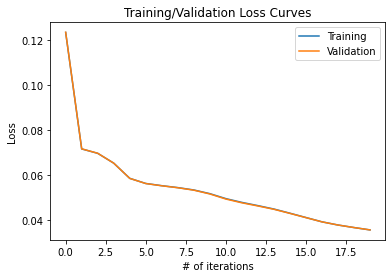

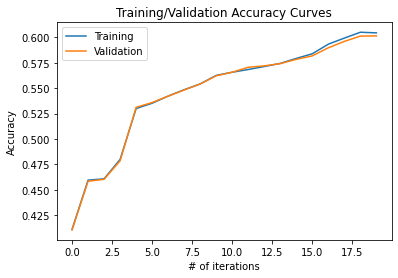

In [ ]:
# get data loader for each dataset
batch_size=64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1)

# Hyperparameters setting
learning_rate=1e-4
epochs=20
batch_size=64

autoencoder = AutoEncoder(hu1=40, hu2=20)
intrations, train_loss, val_loss, train_acc, val_acc = train(autoencoder, train_loader, valid_loader, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)
# plot the training/validation accuracy/loss curves
plotting(intrations, train_loss, val_loss, train_acc, val_acc)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
'''
1st hyperparameters setting:
learning_rate: increasing learning rate to 0.0005 causes the final accuracy increase
epochs: same as initial setting
batch_size: same as initial setting
hidden units: same as initial setting
'''

# Hyperparameters setting
learning_rate=0.0005
epochs=20
batch_size=64

autoencoder = AutoEncoder(hu1=40, hu2=20)
_ = train(autoencoder, train_loader, valid_loader, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)

Training Started...
Epoch 1: Train acc: 53.399, Train loss: 0.0574 | Validation acc: 53.548, Validation loss: 0.05735
Epoch 2: Train acc: 58.212, Train loss: 0.0475 | Validation acc: 58.185, Validation loss: 0.04748
Epoch 3: Train acc: 59.649, Train loss: 0.04005 | Validation acc: 59.654, Validation loss: 0.04013
Epoch 4: Train acc: 60.478, Train loss: 0.0343 | Validation acc: 60.16, Validation loss: 0.03439
Epoch 5: Train acc: 60.591, Train loss: 0.02983 | Validation acc: 60.547, Validation loss: 0.02993
Epoch 6: Train acc: 60.738, Train loss: 0.02659 | Validation acc: 60.482, Validation loss: 0.0268
Epoch 7: Train acc: 61.3, Train loss: 0.02427 | Validation acc: 60.985, Validation loss: 0.02449
Epoch 8: Train acc: 61.564, Train loss: 0.02211 | Validation acc: 61.1, Validation loss: 0.02238
Epoch 9: Train acc: 61.876, Train loss: 0.02014 | Validation acc: 61.372, Validation loss: 0.02039
Epoch 10: Train acc: 61.666, Train loss: 0.01868 | Validation acc: 61.357, Validation loss: 0.0188

In [ ]:
'''
2nd hyperparameters setting:
learning_rate: choosing lr that is bigger or smaller than 0.002555 will not increase the final accuracy, so 0.002555 is the optimal value
epochs: same as initial setting
batch_size: same as initial setting
hidden units: same as initial setting
'''
# Hyperparameters setting
learning_rate=0.002555
epochs=20
batch_size=64

autoencoder = AutoEncoder(hu1=40, hu2=20)
_ = train(autoencoder, train_loader, valid_loader, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)

Training Started...
Epoch 1: Train acc: 58.394, Train loss: 0.03964 | Validation acc: 58.666, Validation loss: 0.03979
Epoch 2: Train acc: 59.986, Train loss: 0.02652 | Validation acc: 59.86, Validation loss: 0.02674
Epoch 3: Train acc: 60.6, Train loss: 0.02234 | Validation acc: 60.333, Validation loss: 0.02254
Epoch 4: Train acc: 60.987, Train loss: 0.01973 | Validation acc: 60.742, Validation loss: 0.01994
Epoch 5: Train acc: 62.645, Train loss: 0.01779 | Validation acc: 62.236, Validation loss: 0.01801
Epoch 6: Train acc: 63.186, Train loss: 0.01695 | Validation acc: 62.786, Validation loss: 0.01723
Epoch 7: Train acc: 63.189, Train loss: 0.01614 | Validation acc: 62.71, Validation loss: 0.01643
Epoch 8: Train acc: 63.16, Train loss: 0.01546 | Validation acc: 62.457, Validation loss: 0.01576
Epoch 9: Train acc: 64.103, Train loss: 0.01472 | Validation acc: 63.712, Validation loss: 0.015
Epoch 10: Train acc: 63.82, Train loss: 0.01413 | Validation acc: 63.354, Validation loss: 0.014

In [ ]:
'''
3rd hyperparameters setting:
learning_rate: choosing lr that is bigger or smaller than 0.002555 will not increase the final accuracy, so 0.002555 is the optimal value
epochs: decreasing number of epochs causes the final accuracy to decrease. Should increase the value in next setting.
batch_size: same as initial setting
hidden units: same as initial setting
'''
# Hyperparameters setting
learning_rate=0.002555
epochs=10
batch_size=64

autoencoder = AutoEncoder(hu1=40, hu2=20)
_ = train(autoencoder, train_loader, valid_loader, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)

Training Started...
Epoch 1: Train acc: 60.167, Train loss: 0.03581 | Validation acc: 60.218, Validation loss: 0.03607
Epoch 2: Train acc: 61.415, Train loss: 0.02511 | Validation acc: 61.408, Validation loss: 0.02536
Epoch 3: Train acc: 61.137, Train loss: 0.02124 | Validation acc: 60.811, Validation loss: 0.0215
Epoch 4: Train acc: 61.118, Train loss: 0.01945 | Validation acc: 60.974, Validation loss: 0.01956
Epoch 5: Train acc: 61.728, Train loss: 0.01802 | Validation acc: 61.632, Validation loss: 0.01804
Epoch 6: Train acc: 62.191, Train loss: 0.01653 | Validation acc: 61.813, Validation loss: 0.01657
Epoch 7: Train acc: 62.532, Train loss: 0.01606 | Validation acc: 62.489, Validation loss: 0.01604
Epoch 8: Train acc: 62.489, Train loss: 0.01538 | Validation acc: 62.305, Validation loss: 0.01537
Epoch 9: Train acc: 63.83, Train loss: 0.01462 | Validation acc: 63.379, Validation loss: 0.01465
Epoch 10: Train acc: 63.014, Train loss: 0.01461 | Validation acc: 62.464, Validation loss:

In [ ]:
'''
4th hyperparameters setting:
learning_rate: choosing lr that is bigger or smaller than 0.002555 will not increase the final accuracy, so 0.002555 is the optimal value
epochs: increasing the number of epochs to 40 increases the final accuracy. Choosing a value that is bigger or smaller than 40 will not increase final accuracy, so 40 is selected as optimal value
batch_size: the initial value is 64. I found that decreasing or increasing the value will not increase the final accuracy. So 64 is selected as optimal value
hidden units: the previous value was 60. Increasing it to 75 increases the final accuracy. Choosing a value that is bigger or smaller than 75 will not increase final accuracy. So 75 is selected as optimal. 
'''

# Hyperparameters setting
learning_rate=0.0025
epochs=40
batch_size=25

autoencoder = AutoEncoder(hu1=45, hu2=30)
_ = train(autoencoder, train_loader, valid_loader, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)

Training Started...
Epoch 1: Train acc: 60.204, Train loss: 0.03533 | Validation acc: 60.348, Validation loss: 0.03553
Epoch 2: Train acc: 61.153, Train loss: 0.02321 | Validation acc: 60.804, Validation loss: 0.02353
Epoch 3: Train acc: 61.418, Train loss: 0.0187 | Validation acc: 61.017, Validation loss: 0.01897
Epoch 4: Train acc: 62.082, Train loss: 0.01657 | Validation acc: 61.849, Validation loss: 0.01675
Epoch 5: Train acc: 62.328, Train loss: 0.01533 | Validation acc: 62.073, Validation loss: 0.01546
Epoch 6: Train acc: 62.958, Train loss: 0.01439 | Validation acc: 62.565, Validation loss: 0.01455
Epoch 7: Train acc: 62.907, Train loss: 0.01341 | Validation acc: 62.453, Validation loss: 0.01348
Epoch 8: Train acc: 63.967, Train loss: 0.01302 | Validation acc: 63.628, Validation loss: 0.01309
Epoch 9: Train acc: 63.208, Train loss: 0.013 | Validation acc: 63.064, Validation loss: 0.01309
Epoch 10: Train acc: 64.775, Train loss: 0.012 | Validation acc: 64.558, Validation loss: 0.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
# Final hyperparameters setting
learning_rate=0.0025
epochs=40
batch_size=25
hu1=45
hu2=30

# loader the chossen setting
autoencoder = AutoEncoder(hu1=hu1, hu2=hu2)
path = get_model_name(autoencoder.name, batch_size=batch_size, learn_rate=learning_rate, epoch=epochs-1)
state = torch.load(path)
autoencoder.load_state_dict(state)

# get testing data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1)
# get accuracy
acc, _ = get_accuracy(autoencoder, test_loader)
print("The final testing accuracy:", round(acc*100, 2), "%")

The final testing accuracy: 70.84 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
# get most common value of each feature 
#sum all records 
summation = train_data.sum(axis=0)
#the max value of the onehot encoding will be the most common value of the feature
baseline_model_output = get_features(summation)
print(baseline_model_output)

# get baseline model accuracy
def get_baseline_model_accuracy(model=baseline_model_output, data_loader=test_loader):
  total = 0
  acc = 0
  counter = 0

  # check each categorical feature
  for feature in catcols:
      for item in data_loader: 
        inp = item.detach().numpy()
        # check each record
        for i in range(len(inp)):
            acc += model[feature] == get_feature(inp[i], feature)
            total += 1
  return acc / total

{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Prof-specialty', 'edu': 'HS-grad', 'relationship': 'Husband', 'sex': 'Male'}


In [ ]:
bs = 1
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1)
accuracy = get_baseline_model_accuracy(baseline_model_output, test_loader) 
print("The accuracy of the baseline model:", round(accuracy*100, 2), "%")

The accuracy of the baseline model: 45.84 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
'''
The test accuracy of my autoencoder from part (a) is higher than the test accuracy of the baseline model in part (b), and my autoencoder model outperforms this baseline model.
'''

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
# get first sample in the testing dataset
dataiter = iter(test_loader)
sample = dataiter.next()
sample = sample[0].numpy()
first_sample = get_features(sample)
print(first_sample)

{'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Transport-moving', 'edu': 'HS-grad', 'relationship': 'Not-in-family', 'sex': 'Male'}


In [ ]:
'''
It is reasonable to guess a person's education level based on their occupation. Because each type of occupation has a minimun education level. 
'''

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
# Final hyperparameters setting
learning_rate=0.0025
epochs=40
batch_size=25
hu1=45
hu2=30

# loader the chossen setting
autoencoder = AutoEncoder(hu1=hu1, hu2=hu2)
path = get_model_name(autoencoder.name, batch_size=batch_size, learn_rate=learning_rate, epoch=epochs-1)
state = torch.load(path)
autoencoder.load_state_dict(state)

# get the first element 
for item in iter(test_loader):
    first_sample = item[0]
    break

# get the sample as loader
first_sample_loader = DataLoader(first_sample.unsqueeze(0))

# get output of the given sample
for item in iter(first_sample_loader): 
    output = autoencoder(zero_out_feature(item, 'edu')).detach().numpy()
    
output = output.squeeze(0)
output = get_features(output)
print(output['edu'])

HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
output = baseline_model_output['edu']
print(output)

HS-grad


In [ ]:
'''
The most common value for education level is also 'HS-grad'
'''